In [15]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [16]:
df = pd.read_csv("/Users/jatinartwani/Documents/Personal/CMU/MISM/Sem2/Measuring Social/Past Lives/pastlives-chart_data-volume-days-pageTypes.csv")

In [17]:
df

,days,06/30/2023,07/01/2023,07/02/2023,07/03/2023,07/04/2023,07/05/2023,07/06/2023,07/07/2023,07/08/2023,...,10/03/2023,10/04/2023,10/05/2023,10/06/2023,10/07/2023,10/08/2023,10/09/2023,10/10/2023,10/11/2023,10/12/2023
0,Online News,79,309,73,71,45,64,137,71,39,...,85,91,88,89,64,60,52,66,51,141
1,QQ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,YouTube,1,0,0,0,0,1,0,1,1,...,1,3,1,2,1,0,0,1,0,0
3,Broadcast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Facebook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Legacy Instagram,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Tumblr,104,120,71,77,78,86,80,77,62,...,101,74,118,139,83,118,106,77,66,105
7,Instagram,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,LinkedIn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Blogs,16,11,19,11,6,9,17,11,15,...,7,6,11,16,2,3,3,6,7,9


In [18]:
engagement = df.copy()

In [19]:
#Transpose Matrix
engagement = engagement.transpose()

In [20]:
#Creating df for Regression Analysis
reg_engagement = df.transpose().copy()

In [21]:
#Calculate Sum of engagements from each source
row_sums = engagement.sum(axis=1)

# Add row sums as a new column
engagement['total'] = row_sums
#engagement['total'] = engagement.iloc[:,6] #Only Forums

#Drop first Row containing all sources
engagement = engagement.drop(engagement.index[0])

#Drop all columns except the 'total' column
columns_to_keep = [engagement.columns[-1]]
engagement = engagement[columns_to_keep]

engagement.index.name = 'date'
engagement.index = pd.to_datetime(engagement.index)

In [22]:
engagement

,total
date,
2023-06-30,1075
2023-07-01,774
2023-07-02,512
2023-07-03,446
2023-07-04,363
...,...
2023-10-08,358
2023-10-09,316
2023-10-10,304


In [23]:
bo = pd.read_csv("/Users/jatinartwani/Documents/Personal/CMU/MISM/Sem2/Measuring Social/Past Lives/pastlives-bo.csv")

In [24]:
bo = bo.dropna(axis=1)

In [25]:
bo

,date,revenue,to_date
0,06/30/2023,"$510,078","$4,821,764"
1,07/01/2023,"$560,814","$5,382,578"
2,07/02/2023,"$589,806","$5,972,384"
3,07/03/2023,"$459,094","$6,431,478"
4,07/04/2023,"$435,672","$6,867,150"
...,...,...,...
100,10/08/2023,"$2,254","$10,985,022"
101,10/09/2023,"$1,318","$10,986,340"
102,10/10/2023,"$2,561","$10,988,901"
103,10/11/2023,$665,"$10,989,566"


In [26]:
#Fixing 'date' column
#bo['date'] = pd.to_datetime(bo['date'] + '-2021', format='%b-%d-%Y')

#bo['date'] = bo['date'].dt.strftime('%m/%d/%Y')

# Making 'date' the index of the DataFrame
bo.set_index('date', inplace=True)

#Remove $ value
bo['revenue'] = bo['revenue'].str.replace('$', '')
bo['revenue'] = bo['revenue'].str.replace(',', '')

In [27]:
bo

,revenue,to_date
date,,
06/30/2023,510078,"$4,821,764"
07/01/2023,560814,"$5,382,578"
07/02/2023,589806,"$5,972,384"
07/03/2023,459094,"$6,431,478"
07/04/2023,435672,"$6,867,150"
...,...,...
10/08/2023,2254,"$10,985,022"
10/09/2023,1318,"$10,986,340"
10/10/2023,2561,"$10,988,901"


In [28]:
engagement['total'] = pd.to_numeric(engagement['total'], errors='coerce')
bo['revenue'] = pd.to_numeric(bo['revenue'], errors='coerce')

In [29]:
engagement_ts = engagement.copy()
bo_ts = bo.copy()

In [30]:
engagement_ts

,total
date,
2023-06-30,1075
2023-07-01,774
2023-07-02,512
2023-07-03,446
2023-07-04,363
...,...
2023-10-08,358
2023-10-09,316
2023-10-10,304


In [31]:
# Combine your datasets into a single DataFrame 
combined_df = pd.concat([engagement_ts['total'], bo_ts['revenue']], axis=1)
combined_df.columns = ['total', 'revenue']

In [32]:
combined_df

,total,revenue
date,,
2023-06-30,1075,510078
2023-07-01,774,560814
2023-07-02,512,589806
2023-07-03,446,459094
2023-07-04,363,435672
...,...,...
2023-10-08,358,2254
2023-10-09,316,1318
2023-10-10,304,2561


In [174]:
#Making Data Stationary

#Differencing
#engagement_ts['total'] = engagement_ts['total'].diff()
#bo_ts['revenue'] = bo_ts['revenue'].diff()


#Taking Logarithm
#engagement_ts['total'] = np.log(engagement_ts['total'])
#bo_ts['revenue'] = bo_ts['revenue'].replace(-np.inf, np.nan)

# Dropping NA values after making it stationary
#engagement_ts.dropna(inplace=True)
#bo_ts.dropna(inplace=True)

In [33]:
#Checking Stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Example usage
check_stationarity(engagement_ts['total'])
check_stationarity(bo_ts['revenue'])

ADF Statistic: -6.755430
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
ADF Statistic: -4.357246
p-value: 0.000353
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


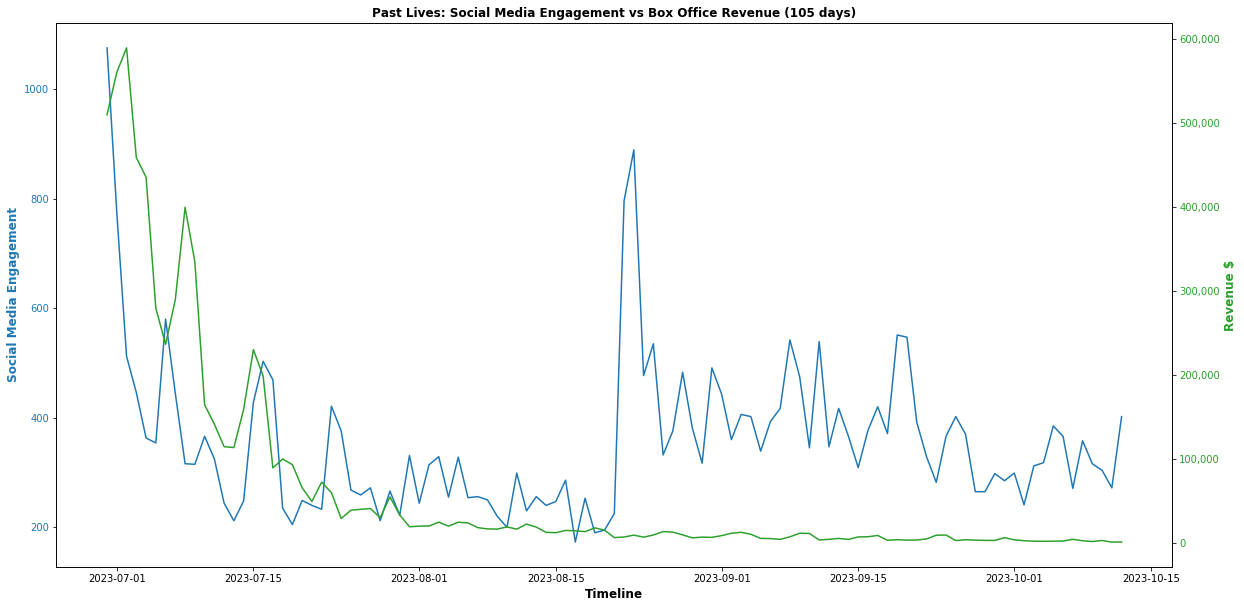

In [34]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:blue'
ax1.set_xlabel('Timeline',fontsize=12,fontweight='bold')
ax1.set_ylabel('Social Media Engagement',color=color,fontsize=12,fontweight='bold')
ax1.plot(combined_df.index,combined_df['total'],color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Revenue $',color=color,fontsize=12,fontweight='bold')
ax2.plot(combined_df.index, combined_df['revenue'],color=color)
ax2.tick_params(axis='y',labelcolor=color)

y_labels = ['{:,.0f}'.format(y) for y in plt.gca().get_yticks()]
plt.gca().set_yticklabels(y_labels)
plt.title('Past Lives: Social Media Engagement vs Box Office Revenue (105 days)',fontsize=12,fontweight='bold')

plt.grid(False)
plt.show()

In [21]:
correlation, _ = pearsonr(combined_df['total'][:60], combined_df['revenue'][:60])
#correlation, _ = pearsonr(combined_df['total'], combined_df['revenue'])

In [22]:
print(f'Pearson correlation coefficient: {correlation}')

Pearson correlation coefficient: 0.3718132549621691


Maximum Pearson correlation coefficient: 0.37181325496216877
Lag associated with Maximum Pearson correlation coefficient: 0


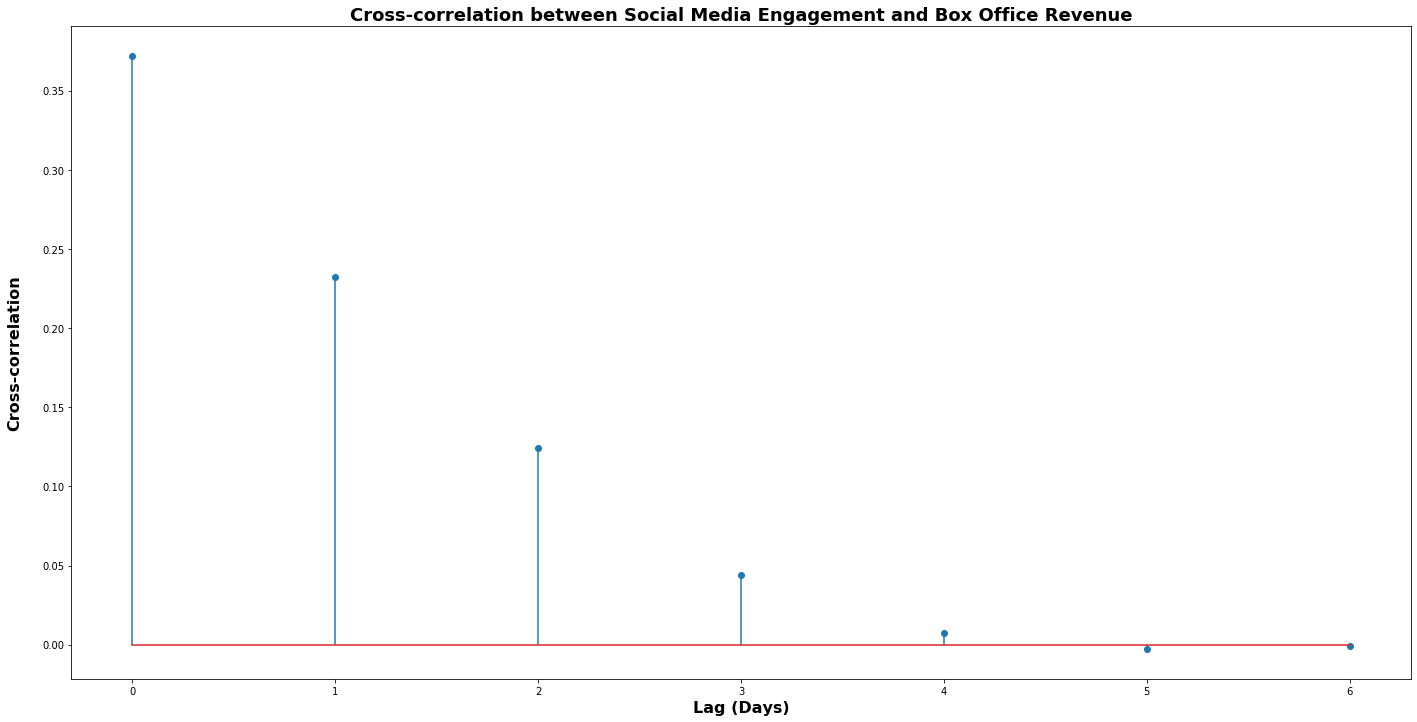

In [36]:
def cross_correlation(series1, series2, lag=0):
    return series1.corr(series2.shift(lag))

# Example usage:
lags = range(0, 7)  # Example lag values from 0 to 12
cross_corr_values = {}
for lag in lags:
    cross_corr_values[lag] = cross_correlation(combined_df['total'], combined_df['revenue'], lag)


max_pair = max(cross_corr_values.items(), key=lambda x: x[1])

#print(cross_corr_values.values())
#cross_corr_values = [cross_correlation(combined_df['total'], combined_df['revenue'], lag) for lag in lags]

print(f'Maximum Pearson correlation coefficient: {max_pair[1]}')
print(f'Lag associated with Maximum Pearson correlation coefficient: {max_pair[0]}')
# Plotting the cross-correlation values
import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))
plt.stem(lags, cross_corr_values.values(), use_line_collection=True)
plt.xlabel('Lag (Days)',fontsize=16,fontweight='bold')
plt.ylabel('Cross-correlation',fontsize=16,fontweight='bold',labelpad=20)
plt.title('Cross-correlation between Social Media Engagement and Box Office Revenue',fontsize=18,fontweight='bold')
plt.show()

In [24]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Combine your datasets into a single DataFrame for the Granger causality test
combined_df = pd.concat([engagement_ts['total'], bo_ts['revenue']], axis=1)
combined_df.columns = ['total', 'revenue']

# Perform the Granger causality test
# The maxlag parameter is the maximum lag to test for, and the test 'ssr_chi2test' is one of the possible tests
granger_test_results = grangercausalitytests(combined_df, maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9575  , df_denom=101, df_num=1
ssr based chi2 test:   chi2=0.0029  , p=0.9567  , df=1
likelihood ratio test: chi2=0.0029  , p=0.9567  , df=1
parameter F test:         F=0.0029  , p=0.9575  , df_denom=101, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0516  , p=0.9498  , df_denom=98, df_num=2
ssr based chi2 test:   chi2=0.1084  , p=0.9472  , df=2
likelihood ratio test: chi2=0.1084  , p=0.9473  , df=2
parameter F test:         F=0.0516  , p=0.9498  , df_denom=98, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6424  , p=0.5896  , df_denom=95, df_num=3
ssr based chi2 test:   chi2=2.0693  , p=0.5581  , df=3
likelihood ratio test: chi2=2.0486  , p=0.5624  , df=3
parameter F test:         F=0.6424  , p=0.5896  , df_denom=95, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6585  , p=0.6224  , df

In [25]:
#Linear Regression Fit
reg_engagement

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
days,Online News,QQ,YouTube,Broadcast,Facebook,Legacy Instagram,Tumblr,Instagram,LinkedIn,Blogs,Forums,Facebook Public,X,VK,Review,Reddit,4Chan
06/30/2023,79,0,1,0,0,0,104,0,0,16,19,5,774,0,2,75,0
07/01/2023,309,0,0,0,0,0,120,0,0,11,27,0,244,0,1,62,0
07/02/2023,73,0,0,0,0,0,71,0,0,19,12,2,263,0,0,72,0
07/03/2023,71,0,0,0,0,0,77,0,0,11,28,3,213,0,2,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/08/2023,60,0,0,0,0,0,118,0,0,3,5,0,136,0,3,33,0
10/09/2023,52,0,0,0,0,0,106,0,0,3,11,1,98,0,1,44,0
10/10/2023,66,0,1,0,0,0,77,0,0,6,43,0,77,0,0,34,0
10/11/2023,51,0,0,0,0,0,66,0,0,7,10,0,104,0,0,34,0


In [26]:
#Make first row as Columns
reg_engagement.columns = reg_engagement.iloc[0]

In [27]:
#Drop first row
reg_engagement = reg_engagement.drop(reg_engagement.index[0])

In [28]:
#Drop Columns (Content Sources where all values are 0)
reg_engagement = reg_engagement.loc[:, (reg_engagement != 0).any(axis=0)]

In [29]:
reg_engagement = reg_engagement.rename(columns={'days': 'date'})

In [30]:
reg_engagement

days,Online News,YouTube,Tumblr,Blogs,Forums,Facebook Public,X,Review,Reddit
06/30/2023,79,1,104,16,19,5,774,2,75
07/01/2023,309,0,120,11,27,0,244,1,62
07/02/2023,73,0,71,19,12,2,263,0,72
07/03/2023,71,0,77,11,28,3,213,2,41
07/04/2023,45,0,78,6,24,4,156,2,48
...,...,...,...,...,...,...,...,...,...
10/08/2023,60,0,118,3,5,0,136,3,33
10/09/2023,52,0,106,3,11,1,98,1,44
10/10/2023,66,1,77,6,43,0,77,0,34
10/11/2023,51,0,66,7,10,0,104,0,34


In [31]:
shift = 0 #Based on Lag

In [32]:
bo_series = bo['revenue']

In [189]:
bo_series

date
11/03/2023    1943167
11/04/2023    1807145
11/05/2023    1289691
11/06/2023     543600
11/07/2023     833067
               ...   
02/10/2024        871
02/11/2024        744
02/12/2024        121
02/13/2024         97
02/14/2024        145
Name: revenue, Length: 104, dtype: int64

In [108]:
bo_series_shifted = bo_series.shift(shift)

In [109]:
bo_series_shifted = bo_series_shifted[:shift]

In [110]:
bo_series_shifted

Series([], Name: revenue, dtype: object)

In [49]:
reg_engagement = reg_engagement.iloc[:shift, :]

In [190]:
reg_engagement

days,Online News,YouTube,Tumblr,Instagram,Blogs,Forums,Facebook Public,X,Review,Reddit
11/03/2023,1494,9,43,0,41,25,10,2446,9,160
11/04/2023,832,3,100,0,20,16,5,545,12,91
11/05/2023,499,6,121,0,20,31,4,322,8,62
11/06/2023,744,12,96,0,24,21,9,242,11,49
11/07/2023,686,14,61,0,12,14,3,321,11,359
...,...,...,...,...,...,...,...,...,...,...
02/10/2024,108,3,44,0,11,4,2,39,13,23
02/11/2024,105,2,138,0,10,4,2,35,2,17
02/12/2024,431,0,73,0,7,8,1,63,2,18
02/13/2024,228,0,68,0,17,9,2,34,1,18


In [33]:
reg_engagement = reg_engagement.astype(int)

In [34]:
reg_engagement

days,Online News,YouTube,Tumblr,Blogs,Forums,Facebook Public,X,Review,Reddit
06/30/2023,79,1,104,16,19,5,774,2,75
07/01/2023,309,0,120,11,27,0,244,1,62
07/02/2023,73,0,71,19,12,2,263,0,72
07/03/2023,71,0,77,11,28,3,213,2,41
07/04/2023,45,0,78,6,24,4,156,2,48
...,...,...,...,...,...,...,...,...,...
10/08/2023,60,0,118,3,5,0,136,3,33
10/09/2023,52,0,106,3,11,1,98,1,44
10/10/2023,66,1,77,6,43,0,77,0,34
10/11/2023,51,0,66,7,10,0,104,0,34


In [53]:
bo_series_shifted

date
03/31/2023    12910476.0
04/01/2023     9072950.0
04/02/2023     2776969.0
04/03/2023     3630908.0
04/04/2023     1863667.0
                 ...    
05/27/2023       46017.0
05/28/2023       34637.0
05/29/2023       14022.0
05/30/2023       13191.0
05/31/2023       10306.0
Name: revenue, Length: 62, dtype: float64

In [35]:
# Prepare the features (X) and the target (y)
X = reg_engagement  # 'Reg Engagement' df as features
y = bo_series  # 'Revenue' series

# Reset index if necessary
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add a constant to the model (for the intercept)
X_scaled_with_const = sm.add_constant(X_scaled)

# Fit the OLS model
model = sm.OLS(y, X_scaled_with_const).fit()

# Get the regression report
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.138
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           0.000161
Time:                        19:29:54   Log-Likelihood:                -1363.9
No. Observations:                 105   AIC:                             2748.
Df Residuals:                      95   BIC:                             2774.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.361e+04   1.09e+04     

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [36]:
# Extract the coefficients (excluding the intercept) and sort them by their absolute values
coefficients = model.params.drop('const').abs().sort_values(ascending=False)

# Print the sorted coefficients to identify the top contributing features
print("\nTop Contributing Features:")
print(coefficients)


Top Contributing Features:
Blogs              37197.753701
X                  34026.352825
YouTube            21241.605840
Tumblr             17302.512518
Facebook Public    11964.072261
Online News        11288.126013
Forums              9714.358479
Reddit              6333.959677
Review              2767.582794
dtype: float64
